In [1]:
# Based from the tutorial of Jason Brownlee on Recurrent Neural Networks
%matplotlib inline

from __future__ import print_function

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"


import numpy as np
import matplotlib.pyplot as plt
import pandas
import math


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')


Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
np.random.seed(10)

In [3]:
#Use the flood_data.csv dataset
dataframe = pandas.read_csv('dataset/flood_train.csv', usecols=[1], engine='python', skipfooter=3)
dataset   = dataframe.values
dataset   = dataset.astype('float32')
dataframe.head()

,waterlevel
0,0.27
1,0.26
2,0.27
3,0.28
4,0.28


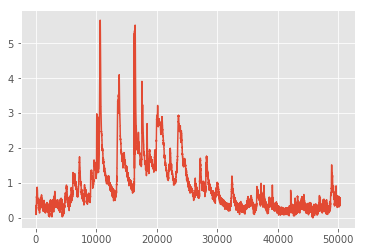

In [4]:
plt.plot(dataset)

In [5]:
# normalize the dataset
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
# split into train and test sets
train_size  = int(len(dataset) * 0.67)
test_size   = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

33710 16604


----------------- TRAINING DATA -----------------


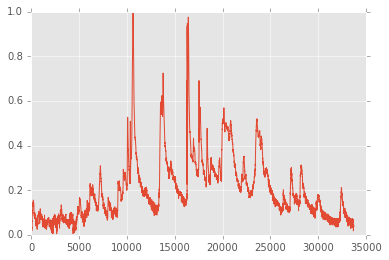

----------------- TEST DATA -----------------


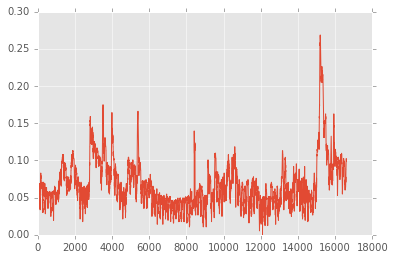

In [7]:
print('----------------- TRAINING DATA -----------------')
plt.plot(train)
plt.show()
print('----------------- TEST DATA -----------------')
plt.plot(test)
plt.show()

In [7]:
# This function creates a sliding window of the dataset.
def create_dataset(dataset, sliding_window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-sliding_window-1):
        a = dataset[i:(i+sliding_window), 0]
        dataX.append(a)
        dataY.append(dataset[i + sliding_window, 0])
    return np.array(dataX), np.array(dataY)

In [8]:
# use a n-10 sliding window equivalent to 2.5 hours of historical data
slide_window   = 10
trainX, trainY = create_dataset(train, slide_window)
testX, testY   = create_dataset(test, slide_window)

In [9]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [10]:
#Setup the LSTM

model = Sequential()
model.add(LSTM(4, input_dim=slide_window))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=50, batch_size=1, verbose=2)

/Users/rohithkumarn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
/Users/rohithkumarn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, input_shape=(None, 10))`
  after removing the cwd from sys.path.
/Users/rohithkumarn/anaconda2/lib/python2.7/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/50
 - 95s - loss: 1.9683e-04
Epoch 2/50
 - 101s - loss: 1.2748e-04
Epoch 3/50
 - 112s - loss: 1.1673e-04
Epoch 4/50
 - 118s - loss: 1.0960e-04
Epoch 5/50
 - 107s - loss: 1.0738e-04
Epoch 6/50
 - 100s - loss: 1.0665e-04
Epoch 7/50
 - 94s - loss: 1.0471e-04
Epoch 8/50
 - 109s - loss: 1.0409e-04
Epoch 9/50
 - 103s - loss: 1.0056e-04
Epoch 10/50
 - 93s - loss: 1.0213e-04
Epoch 11/50
 - 99s - loss: 1.0031e-04
Epoch 12/50
 - 103s - loss: 1.0131e-04
Epoch 13/50
 - 93s - loss: 1.0230e-04
Epoch 14/50
 - 100s - loss: 9.8168e-05
Epoch 15/50
 - 90s - loss: 1.0055e-04
Epoch 16/50
 - 98s - loss: 9.9040e-05
Epoch 17/50
 - 104s - loss: 1.0167e-04
Epoch 18/50
 - 118s - loss: 9.9275e-05
Epoch 19/50
 - 103s - loss: 9.9318e-05
Epoch 20/50
 - 92s - loss: 1.0063e-04
Epoch 21/50
 - 92s - loss: 9.8533e-05
Epoch 22/50
 - 91s - loss: 9.9346e-05
Epoch 23/50
 - 113s - loss: 9.6972e-05
Epoch 24/50
 - 136s - loss: 1.0008e-04
Epoch 25/50
 - 129s - loss: 9.8916e-05
Epoch 26/50
 - 110s - loss: 1.0223e-04
Epoch

In [15]:
# Print out the evaluation for both the
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(np.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.05 RMSE
Test Score: 0.02 RMSE


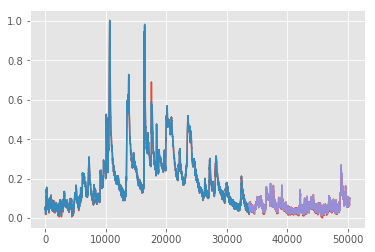

In [16]:
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot       = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[slide_window:len(trainPredict)+slide_window, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot       = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(slide_window*2)+1:len(dataset)-1, :] = testPredict
 
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

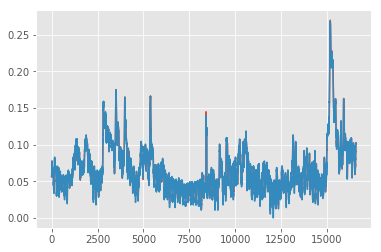

In [17]:
plt.plot(testPredict)
plt.plot(testY)

In [18]:
# Test the network on an unseen data
unseen = pandas.read_csv('dataset/flood_test.csv',sep=',')

In [19]:
unseen.head()

,datetime,rainfall,waterlevel
0,1/1/2013 0:10,0.0,0.21
1,1/1/2013 0:21,0.0,0.21
2,1/1/2013 0:30,0.0,0.40
3,1/1/2013 1:30,0.0,0.49
4,1/1/2013 1:40,0.0,0.59


In [20]:
unseen_test = unseen['waterlevel'].values

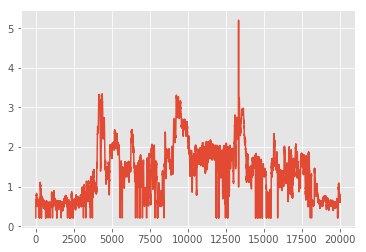

In [21]:
plt.plot(unseen_test[0:20000])

In [22]:
unseen_clean = []
for i in unseen_test:
    unseen_clean.append([i])
unseen_clean = np.asarray(unseen_clean).astype('float32')
unseen_clean = scaler.fit_transform(unseen_clean)

In [23]:
features,labels = create_dataset(unseen_clean, slide_window)
features        = np.reshape(features, (109186,1, 10)) 

In [24]:
unseen_results = model.predict(features)

-------------------- Predicted --------------------


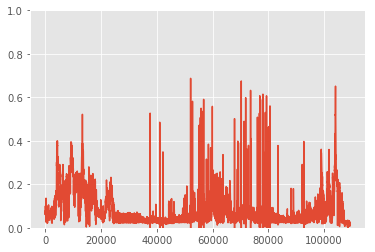

-------------------- Ground Truth --------------------


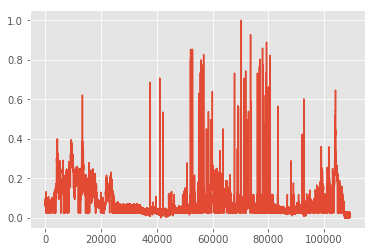

In [25]:
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=1)

print('-------------------- Predicted --------------------')
plt.plot(unseen_results)
plt.show()


print('-------------------- Ground Truth --------------------')
plt.plot(labels)
plt.show()

In [26]:
# Check the root mean squared error for the new test set

testScore = model.evaluate(features, labels, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.16 RMSE


#### It seems that the network is having a hard time predicting higher flood level values
#### Checking the first 20000 data shows that the network is relatively comfortable on predicting ahead of time flood level values when the flood level  aren't extreme

----------------- Predicted ---------------


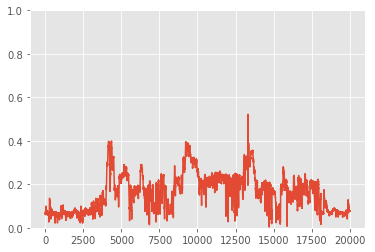

----------------- Ground Truth ---------------


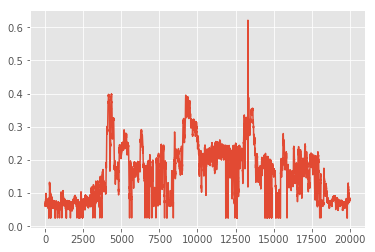

In [27]:
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=1)

print('----------------- Predicted ---------------')
plt.plot(unseen_results[0:20000])
plt.show()

print('----------------- Ground Truth ---------------')
plt.plot(labels[0:20000])
plt.show()

In [ ]:
accuracy=1-testscore
print("Accuarcy"%)